In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pprint import pprint

from typing import Union
from typing import List
from typing import Tuple

%matplotlib inline

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
directory = Path(r'C:\Users\Ivan\Documents\Нетология\Data Scientist\Git\Netology\Диплом')
directory.mkdir(parents=True, exist_ok=True)

In [4]:
def detect_cusum(x, threshold=1, drift=0, ending=False, 
                 show=True, ax=None, merge=False, merge_width=3):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).
    merge: bool, optional (default = False)
        True (1) merges points if they are within the merge width, False (0) doesn't merge.
    merge_width: int, optional, (default = 3)
        sets the window for merging the points

    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).

    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.

    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.

    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.

    See this IPython Notebook [2]_.

    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)

    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]
        
    if merge:
        ta, tai, taf, amp = _merge(ta, tai, taf, amp, merge_width)

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp


def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()
        
def _merge(
    ta: List[int], 
    tai: List[int], 
    taf: List[int], 
    amp: List[float],
    width: int
):
    "Merge points in the same peak."
    if len(ta) == 0:
        return ta, tai, taf, amp

    new_ta = [ta[0]]
    new_tai = [tai[0]]
    new_taf = [taf[0]]
    new_amp = [amp[0]]
    for i in range(1, len(ta)):
        diff = ta[i] - ta[i-1]
        if diff > width:
            new_ta.append(ta[i])
            new_tai.append(tai[i])
            new_taf.append(taf[i])
            new_amp.append(amp[i])
    
    return new_ta, new_tai, new_taf, new_amp
        

In [5]:
def get_timeseries(
    df: pd.DataFrame, 
    mcc_set_one_rus: str,
    start_date: str = '0',
    end_date: str = '0'
) -> dict:
    """Метод для получения временных рядов для данной группы МСС.
    Возвращается в формате словаря:
    {
        MCC: (x, y)
        ...
    }
    """
    mccs = df[df['MCC_SET_ONE_RUS'] == mcc_set_one_rus].MCC.unique().tolist()
    result = {}
    if start_date == '0':
        start_date = df['TRAN_DATE'].min()
    if end_date == '0':
        end_date = df['TRAN_DATE'].max()
    
    for mcc in mccs:
        condition = (
            (df['MCC_SET_ONE_RUS'] == mcc_set_one_rus) 
            & (df['MCC'] == mcc)
            & (df['TRAN_DATE'] >= start_date)
            & (df['TRAN_DATE'] <= end_date)
        )
        x = np.array(df['TRAN_DATE'][condition])
        y = np.array(df['TRAN_COUNT'][condition].apply(int))
        result[mcc] = (x, y)
    
    return result

In [101]:
def visualise(series: dict, grouping: str, mode: str, w_t: float = 0.5, w_d: float = 0.5) -> None:
    """Visualises timeseries or peaks.
    
    grouping:
    * mcc_group - display aggregated mccs
    * mcc_sep - display each mcc in group separately
    
    mode:
    * timeseries - visualise timeseries
    * peaks - visualise peaks
    """
    if grouping == 'mcc_group':
        y_check = True
        for mcc in series:
            if y_check:
                y = series[mcc][1]
                y_check = False
            else:
                y += series[mcc][1]

        x = series[mcc][0]
        if mode == 'timeseries':
            _timeseries(x, y)
        elif mode == 'peaks':
            _peaks(y, w_t, w_d)
    elif grouping == 'mcc_sep':
        for mcc in series:
            y = series[mcc][1]
            x = series[mcc][0]
            if mode == 'timeseries':
                _timeseries(x, y, mcc)
            elif mode == 'peaks':
                _peaks(y, w_t, w_d)

                
def _timeseries(x: np.array, y: np.array, mcc: str = None) -> None:
    mean = np.mean(y)
    median = np.median(y)
    print(f"mean: {mean}")
    print(f"median: {median}")

    plt.figure(figsize=(12, 7))
    if mcc is not None:
        plt.title(f"MCC: {mcc}")
#     plt.grid()
    plt.plot(x, y, label='timeseries')
    plt.hlines(mean, x.min(), x.max(), 'b', 'dashed', 'mean')
    plt.hlines(median, x.min(), x.max(), 'r', 'dashed', 'median')
    plt.legend()
    plt.show()
    

def _peaks(y: np.array, w_t: float=0.5, w_d: float = 0.5, data_print: bool = False) -> None:
    mean = np.mean(y)
    median = np.median(y)
    print(f"w_t: {w_t}")
    print(f"w_d: {w_d}")
    threshold = mean * w_t
    drift = threshold * w_d
    ta, tai, taf, amp = detect_cusum(y, threshold, drift, show=True, ending=True, merge=True)
    if data_print:
        print('ta', ta)
        print('tai', tai)
        print('taf', taf)
        print('amp', amp)

In [91]:
def calculate_weights(y: np.array) -> Tuple[float, float]:
    """calsculates the weights for cumsum algorithm.
    
    w_t - weight for threshold, fraction of mean
    w_d - weight of drift, fraction of threshold
    """
    mean = np.mean(y)
    w_t = 2
    w_d = 0.5
    threshold = mean * w_t
    drift = threshold * w_d
    ta = []      
    count = 0
    while len(ta) < 2:
        count += 1
        if count > 1999:
            w_t = 1
            break
        w_t *= 0.99
        threshold = mean * w_t
        drift = threshold * w_d

        ta, tai, taf, amp = detect_cusum(y, threshold, drift, show=False, ending=True, merge=True)
        
    count = 0
    w_t_save = w_t
    while len(ta) > 3:
        count += 1
        if count > 1999:
            w_t = w_t_save
            break
        w_t *= 1.01
        threshold = mean * w_t
        drift = threshold * w_d

        ta, tai, taf, amp = detect_cusum(y, threshold, drift, show=False, ending=True, merge=True)

    length = len(ta)
    count = 0
    while len(ta) < length + 1:
        count += 1
        if count > 999:
            w_d = 0.5
            break
        w_d *= 0.99
        drift = threshold * w_d

        ta, tai, taf, amp = detect_cusum(y, threshold, drift, show=False, ending=True, merge=True)
    
    return w_t, w_d

In [92]:
def find_weights(
    df: pd.DataFrame,
    mcc_list: List[str], 
    start_date: str, 
    end_date: str,
    mode: str = 'micro',
    verbose: bool = False
) -> dict:
    """
    """
    weights = {}

    for name in mcc_list:
        if verbose:
            print(name)
        series = get_timeseries(df, name, start_date, end_date)
        w_t_list, w_d_list = [], []
        for mcc in series:
            y = series[mcc][1]
            w_t, w_d = calculate_weights(y)
            w_t_list.append(w_t)
            w_d_list.append(w_d)

        index = w_t_list.index(min(w_t_list))

        weights[name] = (w_t_list[index], w_d_list[index])
        if verbose:
            pprint(weights[name])
                
    return weights

In [93]:
path = directory.joinpath('mcc_data_masked.csv')
df = pd.read_csv(path, engine='python')

In [94]:
mcc_of_interest = df.MCC_SET_ONE_RUS.unique()

In [83]:
weights = find_weights(df, mcc_of_interest, '2019-01-01', '2020-01-01', verbose=False)

In [84]:
pprint(weights)

{0: (1.07253645041437, 0.1963555141789025),
 1: (0.3965485131778289, 0.1963555141789025),
 2: (1.6358138751944613, 0.05479145278167411),
 3: (0.4897305980698589, 0.46603267395349496),
 4: (0.5047213261786923, 0.480298005),
 5: (0.8860959632523451, 0.19244803944674235),
 6: (0.3550450535175269, 0.3811713571735518),
 7: (0.4704332584808202, 0.48514949999999996),
 8: (0.4384745387329447, 0.38502157290257755),
 9: (0.3771136903347543, 0.08190398485404372),
 10: (0.4211968923934571, 0.47549502494999996),
 11: (0.2992828112072313, 0.44766912712935814),
 12: (0.6170889412693021, 0.49005),
 13: (2.275958942210493, 0.48514949999999996),
 14: (0.3847706257879342, 0.3698501866941401),
 15: (0.3276159394161749, 0.24249568513708142),
 16: (0.47518510957658605, 0.2791330692739319),
 17: (0.6823321230280849, 0.40486393411062915),
 18: (0.668753713779826, 0.37735964360181623),
 19: (0.40868692349247904, 0.2329403875848967)}


w_t: 0.3965485131778289
w_d: 0.1963555141789025


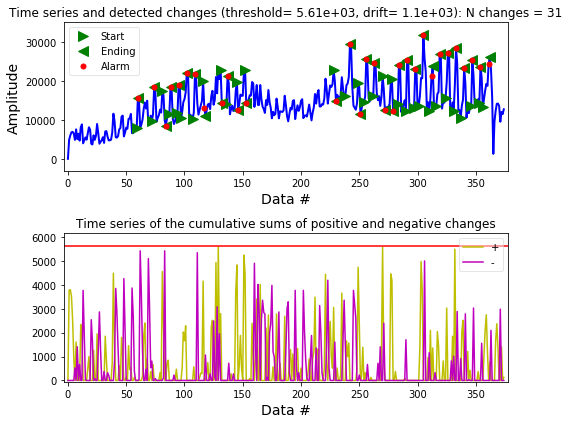

w_t: 0.3965485131778289
w_d: 0.1963555141789025


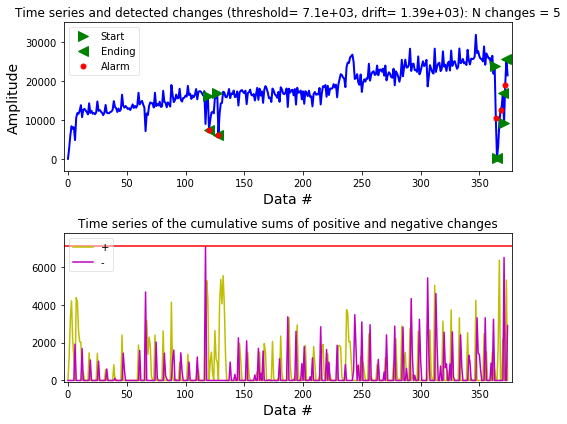

w_t: 0.3965485131778289
w_d: 0.1963555141789025


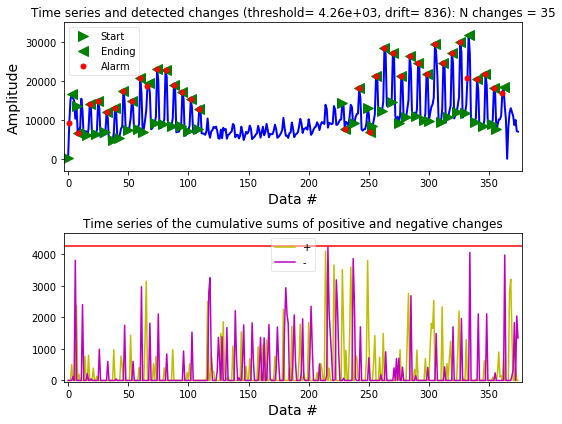

w_t: 0.3965485131778289
w_d: 0.1963555141789025


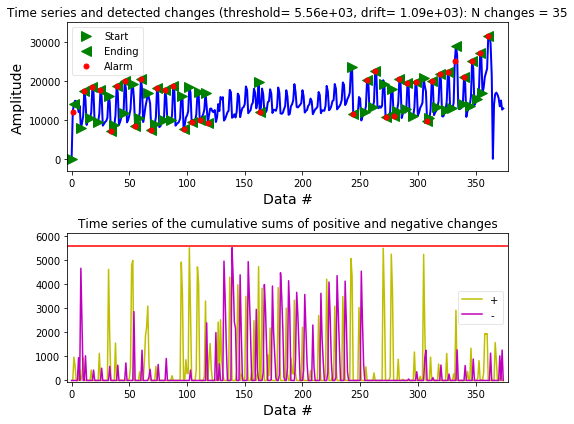

w_t: 0.3965485131778289
w_d: 0.1963555141789025


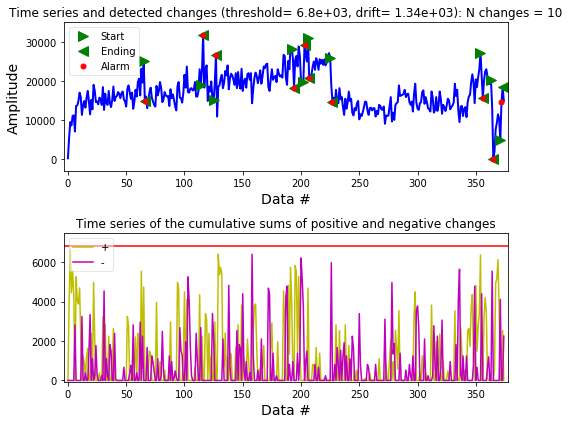

w_t: 0.3965485131778289
w_d: 0.1963555141789025


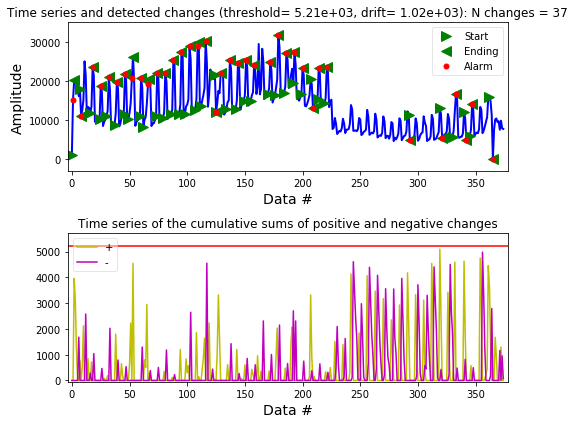

w_t: 0.3965485131778289
w_d: 0.1963555141789025


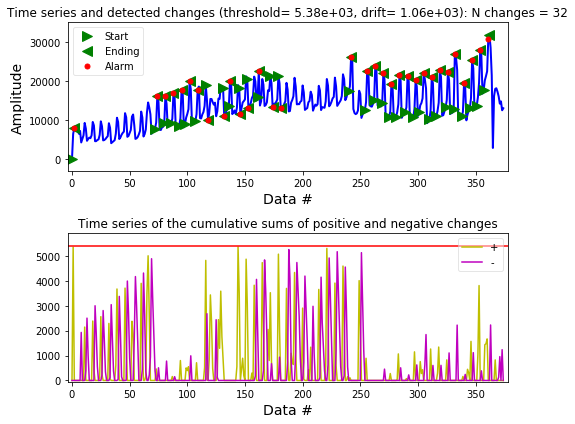

w_t: 0.3965485131778289
w_d: 0.1963555141789025


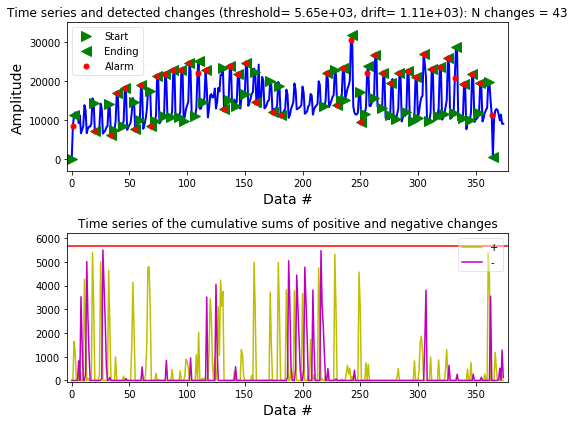

w_t: 0.3965485131778289
w_d: 0.1963555141789025


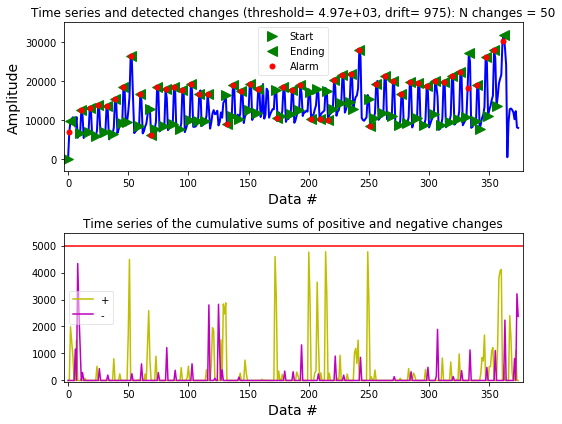

w_t: 0.3965485131778289
w_d: 0.1963555141789025


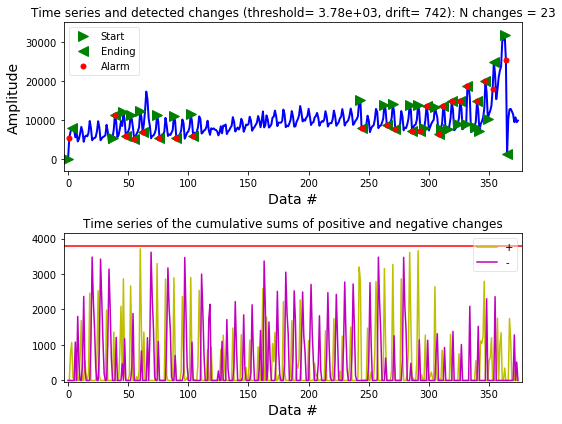

w_t: 0.3965485131778289
w_d: 0.1963555141789025


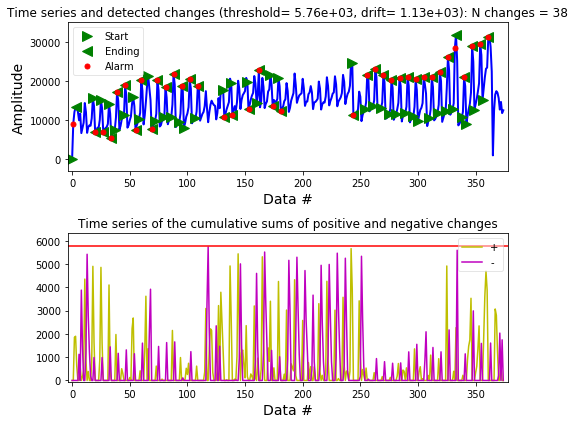

w_t: 0.3965485131778289
w_d: 0.1963555141789025


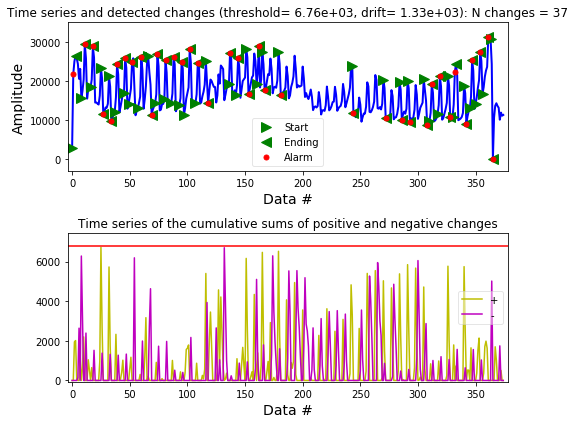

w_t: 0.3965485131778289
w_d: 0.1963555141789025


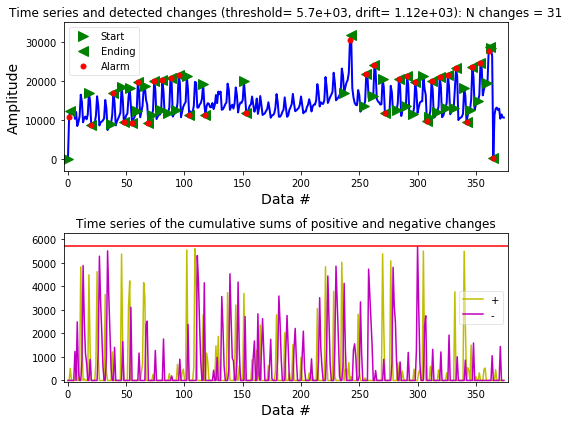

w_t: 0.3965485131778289
w_d: 0.1963555141789025


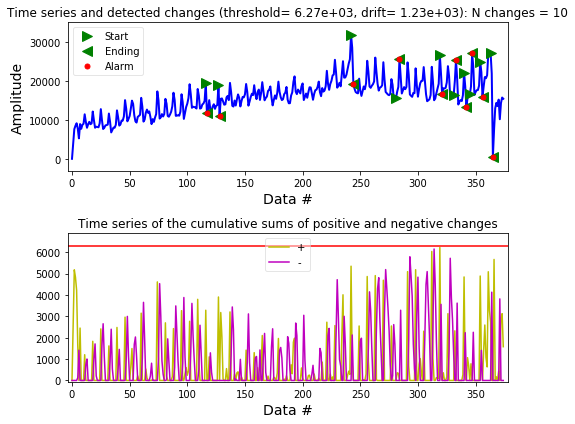

In [103]:
mcc_sor = 1
series = get_timeseries(df, mcc_sor)
visualise(series, grouping='mcc_sep', mode='peaks', w_t=weights[mcc_sor][0], w_d=weights[mcc_sor][1])

In [55]:
series = get_timeseries(df, mcc_sor)

MCC: 0


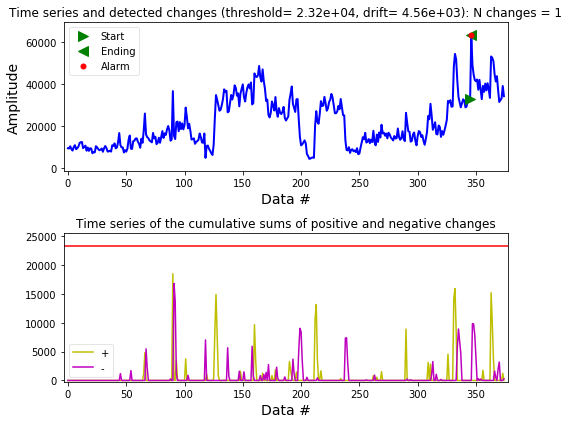

MCC: 47


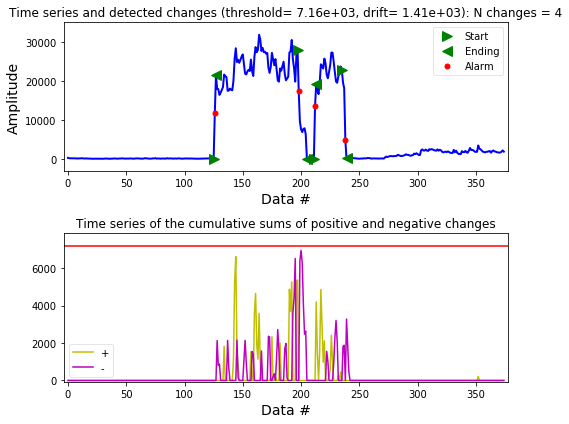

MCC: 95


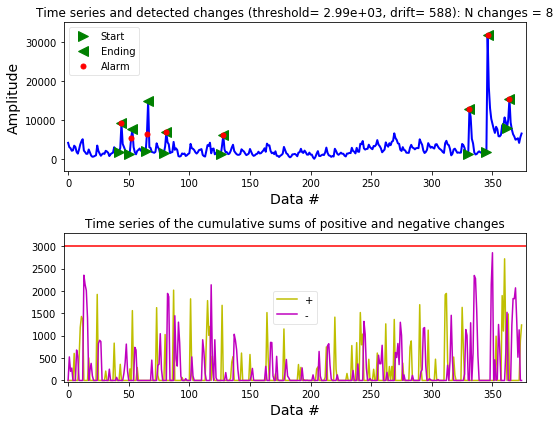

MCC: 98


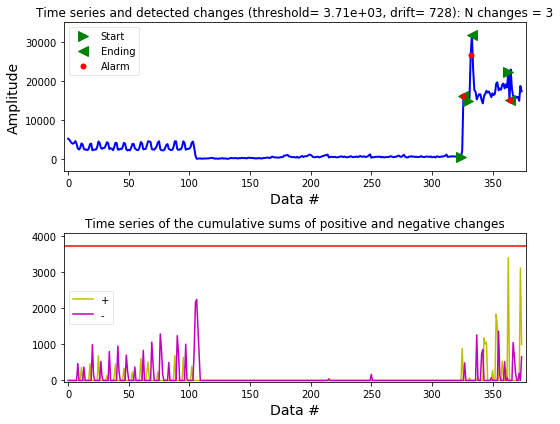

In [57]:
visualise(series, grouping='mcc_sep', mode='peaks', w_t=weights[mcc_sor][0], w_d=weights[mcc_sor][1])